In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:
import os
import pandas as pd
import tensorflow as tf
from PIL import ImageFile

# Fix truncated image errors
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [6]:
import pandas as pd

csv_path = "/content/drive/My Drive/FracAtlas/FracAtlas/dataset.csv"   # <-- CHANGE if needed

df = pd.read_csv(csv_path)

print("Columns:", df.columns)
print("\nFirst 5 rows:\n", df.head())
print("\nUnique values in fractured column:", df['fractured'].unique())
print("\nTotal rows:", len(df))


Columns: Index(['image_id', 'hand', 'leg', 'hip', 'shoulder', 'mixed', 'hardware',
       'multiscan', 'fractured', 'fracture_count', 'frontal', 'lateral',
       'oblique'],
      dtype='object')

First 5 rows:
          image_id  hand  leg  hip  shoulder  mixed  hardware  multiscan  \
0  IMG0000000.jpg     0    1    0         0      0         0          1   
1  IMG0000001.jpg     0    1    0         0      0         0          1   
2  IMG0000002.jpg     0    1    0         0      0         0          1   
3  IMG0000003.jpg     0    1    0         0      0         0          1   
4  IMG0000004.jpg     0    1    0         0      0         0          1   

   fractured  fracture_count  frontal  lateral  oblique  
0          0               0        1        1        0  
1          0               0        1        1        0  
2          0               0        1        1        0  
3          0               0        0        1        1  
4          0               0        0        1

In [7]:
import os

# Base folder
base_path = "/content/drive/My Drive/FracAtlas/FracAtlas/images"

def get_full_path(row):
    folder = "Fractured" if row['fractured'] == 1 else "Non_fractured"
    return os.path.join(base_path, folder, row['image_id'])

df['image_path'] = df.apply(get_full_path, axis=1)

print(df.tail())
print("\nChecking if files exist...")

missing = []
for p in df['image_path'].values:
    if not os.path.exists(p):
        missing.append(p)

print("Total missing images:", len(missing))
print("First 5 missing files:", missing[:5])


            image_id  hand  leg  hip  shoulder  mixed  hardware  multiscan  \
4078  IMG0004375.jpg     1    0    0         0      0         0          0   
4079  IMG0004376.jpg     1    0    0         0      0         0          0   
4080  IMG0004383.jpg     0    1    0         0      0         0          0   
4081  IMG0004388.jpg     0    1    0         0      0         0          0   
4082  IMG0004389.jpg     0    0    1         0      0         0          0   

      fractured  fracture_count  frontal  lateral  oblique  \
4078          1               1        0        1        0   
4079          1               1        1        0        0   
4080          0               0        1        0        0   
4081          0               0        0        1        0   
4082          0               0        1        0        0   

                                             image_path  
4078  /content/drive/My Drive/FracAtlas/FracAtlas/im...  
4079  /content/drive/My Drive/FracAtlas/Fr

In [8]:
# Create a new clean dataframe for training
clean_df = df[['image_path', 'fractured']].copy()

# Rename 'fractured' → 'label'
clean_df.rename(columns={'fractured': 'label'}, inplace=True)

print(clean_df.head())
print(clean_df['label'].value_counts())
print("Total rows:", len(clean_df))


                                          image_path  label
0  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
1  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
2  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
3  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
4  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
label
0    3366
1     717
Name: count, dtype: int64
Total rows: 4083


In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    clean_df,
    test_size=0.15,
    random_state=42,
    stratify=clean_df['label']
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

print("\nTrain label distribution:")
print(train_df['label'].value_counts())

print("\nValidation label distribution:")
print(val_df['label'].value_counts())


Train size: 3470
Val size: 613

Train label distribution:
label
0    2861
1     609
Name: count, dtype: int64

Validation label distribution:
label
0    505
1    108
Name: count, dtype: int64


In [10]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load and preprocess images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # IMPORTANT
    return image, label

# TRAIN dataset
train_data = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)

train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(2000)
train_data = train_data.batch(32)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

# VALIDATION dataset
val_data = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label'].values)
)

val_data = val_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.batch(32)
val_data = val_data.prefetch(tf.data.AUTOTUNE)

print(train_data)
print(val_data)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load EfficientNetB0 base model
base_model = EfficientNetB0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

base_model.trainable = False  # Freeze base layers initially

# Build model
inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,972 (15.47 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [12]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # EfficientNet preprocessing
    return image, label

# Convert Pandas DataFrame to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label'].values)
)
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Stop training if val_loss does not improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce learning rate by factor of 0.2 if val_loss does not improve for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:10 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) INVALID_ARGUMENT:  Error in user-defined function passed to ParallelMapDatasetV2:10 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_16982]

In [16]:
import tensorflow as tf
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)

def load_image_safe(path, label):
    def _load(path_str):
        img = Image.open(path_str.decode('utf-8')).convert('RGB')  # force RGB
        img = img.resize(IMG_SIZE)
        img = np.array(img)
        img = preprocess_input(img)
        return img.astype(np.float32)

    image = tf.py_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    label = tf.cast(label, tf.float32)
    return image, label


In [17]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)
train_ds = train_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(32).prefetch(tf.data.AUTOTUNE)


In [18]:
import pandas as pd
import os

# Load your CSV
csv_path = "/content/drive/My Drive/FracAtlas/FracAtlas/dataset.csv"
df = pd.read_csv(csv_path)

# Base folder where images are stored
base_path = "/content/drive/My Drive/FracAtlas/FracAtlas/images"

# Create 'image_path' column
def get_full_path(row):
    folder = "Fractured" if row['fractured'] == 1 else "Non_fractured"
    return os.path.join(base_path, folder, row['image_id'])

df['image_path'] = df.apply(get_full_path, axis=1)

# Create 'label' column (same as 'fractured')
df['label'] = df['fractured']

# Quick check
print("Total rows:", len(df))
print(df[['image_path', 'label']].head())


Total rows: 4083
                                          image_path  label
0  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
1  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
2  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
3  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0
4  /content/drive/My Drive/FracAtlas/FracAtlas/im...      0


In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input

# Split into train and validation (85% train, 15% val)
train_df, val_df = train_test_split(
    df[['image_path', 'label']],
    test_size=0.15,
    stratify=df['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))

# Parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Function to safely load images with PIL
def load_image_safe(path, label):
    def _load(path_str):
        img = Image.open(path_str.decode('utf-8')).convert('RGB')  # force RGB
        img = img.resize(IMG_SIZE)
        img = np.array(img)
        img = preprocess_input(img)  # EfficientNet preprocessing
        return img.astype(np.float32)

    image = tf.py_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    label = tf.cast(label, tf.float32)
    return image, label

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)
train_ds = train_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label'].values)
)
val_ds = val_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Quick check
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Batch labels:", labels.numpy())


Train size: 3470
Val size: 613


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:25 transformation with iterator: Iterator::Root::Prefetch::FiniteTake::Prefetch::BatchV2::Shuffle::ParallelMapV2: AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'decode'
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/__autograph_generated_filerkv_xgvf.py", line 16, in _load
    img = ag__.converted_call(ag__.converted_call(ag__.ld(Image).open, (ag__.converted_call(ag__.ld(path_str).decode, ('utf-8',), None, fscope_1),), None, fscope_1).convert, ('RGB',), None, fscope_1)
                                                                                            ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/tensor.py", line 260, in __getattr__
    self.__getattribute__(name)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'decode'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

In [20]:
def load_image_safe(path, label):
    def _load(path_str):
        path_str = path_str.numpy().decode('utf-8')  # convert EagerTensor -> string
        img = Image.open(path_str).convert('RGB')    # force RGB
        img = img.resize(IMG_SIZE)
        img = np.array(img)
        img = preprocess_input(img)
        return img.astype(np.float32)

    image = tf.py_function(_load, [path], tf.float32)
    image.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    label = tf.cast(label, tf.float32)
    return image, label


In [21]:
# Create TensorFlow datasets from the DataFrames
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
)
train_ds = train_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['image_path'].values, val_df['label'].values)
)
val_ds = val_ds.map(load_image_safe, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Quick sanity check
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Batch labels:", labels.numpy())


Batch image shape: (32, 224, 224, 3)
Batch labels: [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Base EfficientNetB0 (include_top=False)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_layer)

# Global Average Pooling
x = GlobalAveragePooling2D()(base_model.output)

# Batch Normalization
x = BatchNormalization()(x)

# Dropout for regularization
x = Dropout(0.5)(x)

# Final dense layer (binary classification)
output = Dense(1, activation='sigmoid')(x)

# Build model
model = Model(inputs=input_layer, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)



In [23]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 887s 7s/step - accuracy: 0.5705 - loss: 0.9097 - val_accuracy: 0.8173 - val_loss: 0.4816 - learning_rate: 1.0000e-04
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - accuracy: 0.7280 - loss: 0.5813 - val_accuracy: 0.8581 - val_loss: 0.3807 - learning_rate: 1.0000e-04
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 418ms/step - accuracy: 0.8150 - loss: 0.4281 - val_accuracy: 0.8515 - val_loss: 0.4162 - learning_rate: 1.0000e-04
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 421ms/step - accuracy: 0.8731 - loss: 0.3202 - val_accuracy: 0.8809 - val_loss: 0.3358 - learning_rate: 1.0000e-04
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 416ms/step - accuracy: 0.9009 - loss: 0.2595 - val_accuracy: 0.8940 - val_loss: 0.3256 - learning_rate: 1.0000e-04
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 412ms/step - accuracy: 0.9288 - loss: 0.1992 - val_accuracy: 0.8744 - val_loss: 0.3391 - learning_rate: 1.0000e-04
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 420m

In [24]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.8999 - loss: 0.2876
Validation Loss: 0.2951
Validation Accuracy: 0.9005


In [25]:
import numpy as np

# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # threshold 0.5 for binary

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_true, y_pred, target_names=['Non-fracture', 'Fracture'])
print("Classification Report:")
print(report)


Confusion Matrix:
[[491  14]
 [ 47  61]]
Classification Report:
              precision    recall  f1-score   support

Non-fracture       0.91      0.97      0.94       505
    Fracture       0.81      0.56      0.67       108

    accuracy                           0.90       613
   macro avg       0.86      0.77      0.80       613
weighted avg       0.90      0.90      0.89       613



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


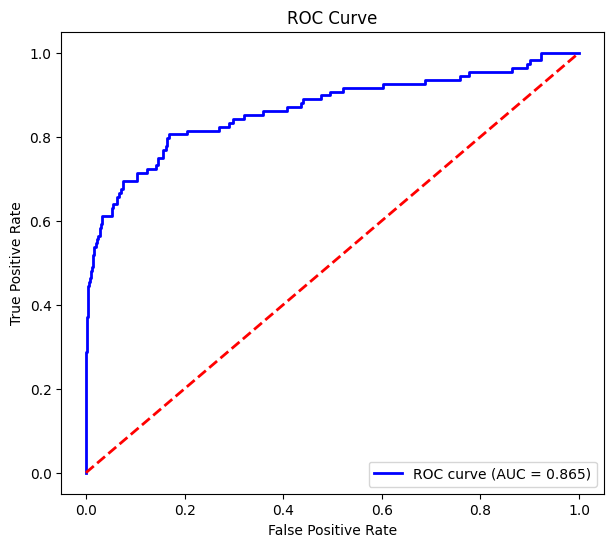

AUC: 0.865


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class
y_prob = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_prob.extend(preds.flatten())

y_prob = np.array(y_prob)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc:.3f}")


In [28]:
# Save as .keras
model_save_path = "/content/drive/My Drive/FracAtlas/FracAtlas/fracture_model.keras"
model.save(model_save_path)
print("Model saved at:", model_save_path)


Model saved at: /content/drive/My Drive/FracAtlas/FracAtlas/fracture_model.keras


In [29]:
from tensorflow.keras.models import load_model

# Load model
loaded_model = load_model(model_save_path)
print("Model loaded successfully!")


Model loaded successfully!


In [30]:
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = loaded_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())  # threshold 0.5

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [31]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("Validation Accuracy:", acc)

# F1-score
f1 = f1_score(y_true, y_pred)
print("Validation F1-score (Fracture class):", f1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Full classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Non-fracture','Fracture']))


Validation Accuracy: 0.9004893964110929
Validation F1-score (Fracture class): 0.6666666666666666
Confusion Matrix:
 [[491  14]
 [ 47  61]]
Classification Report:
               precision    recall  f1-score   support

Non-fracture       0.91      0.97      0.94       505
    Fracture       0.81      0.56      0.67       108

    accuracy                           0.90       613
   macro avg       0.86      0.77      0.80       613
weighted avg       0.90      0.90      0.89       613



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


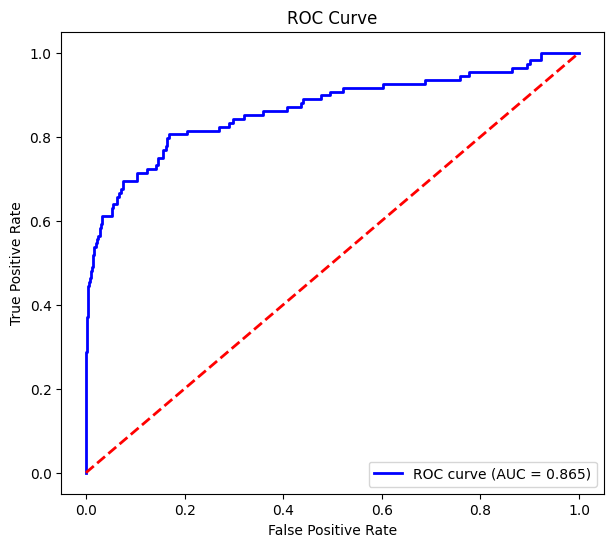

AUC: 0.865


In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class (fracture)
y_prob = []

for images, labels in val_ds:
    preds = loaded_model.predict(images)
    y_prob.extend(preds.flatten())

y_prob = np.array(y_prob)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"AUC: {roc_auc:.3f}")


In [33]:
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, img_size=(224,224), show_image=True):
    """
    Predicts fracture on a single image.

    Args:
        model : loaded keras model
        image_path : str, path to image
        img_size : tuple, (height, width)
        show_image : bool, whether to display the image

    Returns:
        prob : float, predicted probability of fracture
        label : str, predicted class ('Fracture' or 'Non-fracture')
    """
    # Load image
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size)
    img_array = np.array(img)

    # Preprocess
    img_array = preprocess_input(img_array.astype(np.float32))
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    prob = model.predict(img_array)[0][0]
    label = "Fracture" if prob > 0.5 else "Non-fracture"

    # Show image
    if show_image:
        plt.imshow(img)
        plt.title(f"{label} ({prob:.3f})")
        plt.axis('off')
        plt.show()

    return prob, label


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


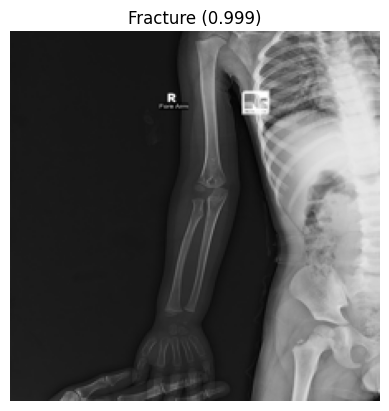

Predicted label: Fracture, Probability: 0.999


In [34]:
image_path = "/content/drive/My Drive/FracAtlas/FracAtlas/images/Fractured/IMG0000188.jpg"
prob, label = predict_image(loaded_model, image_path)
print(f"Predicted label: {label}, Probability: {prob:.3f}")


In [35]:
import os
import pandas as pd
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np

# --- Parameters ---
img_size = (224, 224)
batch_folders = {
    "Fractured": 1,
    "Non_fractured": 0
}
base_path = "/content/drive/My Drive/FracAtlas/FracAtlas/images"

# --- List to store results ---
results = []

# --- Loop through folders ---
for folder_name, true_label in batch_folders.items():
    folder_path = os.path.join(base_path, folder_name)
    for img_file in os.listdir(folder_path):
        if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(folder_path, img_file)

            # Load and preprocess image
            img = Image.open(image_path).convert('RGB')
            img = img.resize(img_size)
            img_array = np.array(img).astype(np.float32)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # Predict
            prob = loaded_model.predict(img_array, verbose=0)[0][0]
            pred_label = 1 if prob > 0.5 else 0

            # Save results
            results.append({
                "image_path": image_path,
                "true_label": true_label,
                "predicted_label": pred_label,
                "predicted_probability": prob
            })

# --- Convert to DataFrame ---
results_df = pd.DataFrame(results)

# --- Save CSV ---
results_csv = "/content/drive/My Drive/FracAtlas/FracAtlas/batch_predictions.csv"
results_df.to_csv(results_csv, index=False)
print(f"Batch predictions saved at: {results_csv}")

# --- Quick summary ---
print(results_df.head())
print("Prediction counts:")
print(results_df['predicted_label'].value_counts())


Batch predictions saved at: /content/drive/My Drive/FracAtlas/FracAtlas/batch_predictions.csv
                                          image_path  true_label  \
0  /content/drive/My Drive/FracAtlas/FracAtlas/im...           1   
1  /content/drive/My Drive/FracAtlas/FracAtlas/im...           1   
2  /content/drive/My Drive/FracAtlas/FracAtlas/im...           1   
3  /content/drive/My Drive/FracAtlas/FracAtlas/im...           1   
4  /content/drive/My Drive/FracAtlas/FracAtlas/im...           1   

   predicted_label  predicted_probability  
0                1               0.945275  
1                1               0.515052  
2                1               0.998577  
3                1               0.996418  
4                1               0.999990  
Prediction counts:
predicted_label
0    3420
1     663
Name: count, dtype: int64
